In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Paths and stuff
import os
import sys

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [2]:
surfvel_data_40kms = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/surfvel_data_40kms.nc")
vx_uncert_data = surfvel_data_40kms["vx_uncert"].data
vy_uncert_data = surfvel_data_40kms["vy_uncert"].data

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")

zs_data = H_data_40["zs"].data
mask_zs = zs_data >= -50.0
mask_zs = mask_zs.astype(float)

In [3]:
sicopolis_dir = '/home/shreyas/update_to_develop_sicopolis/sicopolis_tuneCS_mini'
simulation = 'grl40_bm5_paleo17a_nudged_CT4_BH0_SVC_m21ka_pkp'
dict_sico_out_folder_prefixes = {"nodiff": "N",
                                 "tlm": "FORWARD",
                                 "adj": "ADJOINT",
                                 "tlm_action": "FORWARDHESSACTION",
                                 "adj_action": "ADJHESSACTION"}
dict_ad_exec_cmds_suffixes = {"nodiff": "nodiff",
                              "tlm": "forward",
                              "adj": "adjoint",
                              "tlm_action": "forwardhessaction",
                              "adj_action": "adjointhessaction"}
dict_ad_log_file_suffixes = {"nodiff": "nodiff",
                             "tlm": "tlm",
                             "adj": "adj",
                             "tlm_action": "tlm_hessaction",
                             "adj_action": "adj_hessaction"}
dict_ad_nc_suffixes = {"nodiff": "nodiff",
                       "tlm": "tlm",
                       "adj": "adj",
                       "tlm_action": "tlm_hessaction",
                       "adj_action": "adj_hessaction"}

KCMAX = 80
exp_sigma_level = dataCleaner.exp_sigma_level(zeta = np.arange(0,1+1./KCMAX,1./KCMAX),
                                              exponent = 2.0)
xModel40       = np.arange(-72.,97.,4.0)*10
yModel40       = np.arange(-345.,-56.,4.0)*10
time_ad = np.arange(12, dtype=float)
IMAX = xModel40.shape[0]-1
JMAX = yModel40.shape[0]-1

log_c_slide_init = np.log10(8.5)*np.ones((JMAX+1, IMAX+1))
log_p_weert = np.log10(3.0)
log_q_weert = np.log10(2.0)
log_enh_fact_da_dummy2d_scalar = np.log10(3.0)
log_enh_intg_da_dummy2d_scalar = np.log10(1.0)

# Ensure the sequence in these arrays is the same as defined in ad_specs.h
dict_og_params_fields_vals = {"xx_c_slide_init": log_c_slide_init,
                              "xx_p_weert": log_p_weert,
                              "xx_q_weert": log_q_weert,
                              "xx_enh_fact_da_dummy2d_scalar": log_enh_fact_da_dummy2d_scalar,
                              "xx_enh_intg_da_dummy2d_scalar": log_enh_intg_da_dummy2d_scalar}
dict_params_fields_num_dims = {"xx_c_slide_init": "2D",
                               "xx_p_weert": "2D",
                               "xx_q_weert": "2D",
                               "xx_enh_fact_da_dummy2d_scalar": "2D",
                               "xx_enh_intg_da_dummy2d_scalar": "2D"}
dict_params_coords = {"time_ad": time_ad,
                      "zeta_c": exp_sigma_level,
                      "y": yModel40,
                      "x": xModel40}
dict_params_attrs_type = {"xx_c_slide_init": "nodiff",
                          "xx_p_weert": "nodiff",
                          "xx_q_weert": "nodiff",
                          "xx_enh_fact_da_dummy2d_scalar": "nodiff",
                          "xx_enh_intg_da_dummy2d_scalar": "nodiff"}
dict_params_fields_or_scalars = {"xx_c_slide_init": "field",
                                 "xx_p_weert": "scalar",
                                 "xx_q_weert": "scalar",
                                 "xx_enh_fact_da_dummy2d_scalar": "scalar",
                                 "xx_enh_intg_da_dummy2d_scalar": "scalar"}

year2sec = 3.1556925445e+07
sec2year = 1/year2sec
dict_masks_observables = {"vx_s_g": mask_zs*(vx_uncert_data*sec2year)**(-2),
                          "vy_s_g": mask_zs*(vy_uncert_data*sec2year)**(-2)}

dict_prior_sigmas = {"xx_c_slide_init": 0.3,
                     "xx_p_weert": 0.3,
                     "xx_q_weert": 0.3,
                     "xx_enh_fact_da_dummy2d_scalar": 0.3,
                     "xx_enh_intg_da_dummy2d_scalar": 0.3}
dict_prior_gammas = {"xx_c_slide_init": 1.0,
                     "xx_p_weert": 0.0,
                     "xx_q_weert": 0.0,
                     "xx_enh_fact_da_dummy2d_scalar": 0.0,
                     "xx_enh_intg_da_dummy2d_scalar": 0.0}
dict_prior_deltas = {"xx_c_slide_init": 1.e-5,
                     "xx_p_weert": 0.0,
                     "xx_q_weert": 0.0,
                     "xx_enh_fact_da_dummy2d_scalar": 0.0,
                     "xx_enh_intg_da_dummy2d_scalar": 0.0}

list_fields_to_ignore = ["xx_p_weert", "xx_q_weert", "xx_enh_fact_da_dummy2d_scalar", "xx_enh_intg_da_dummy2d_scalar"]

# all_fields = ["xx_c_slide_init",
#               "xx_p_weert", "xx_q_weert",
#               "xx_enh_fact_da_dummy2d_scalar", "xx_enh_intg_da_dummy2d_scalar"]

MAX_ITERS_SOR = 1000
OMEGA_SOR = 1.5

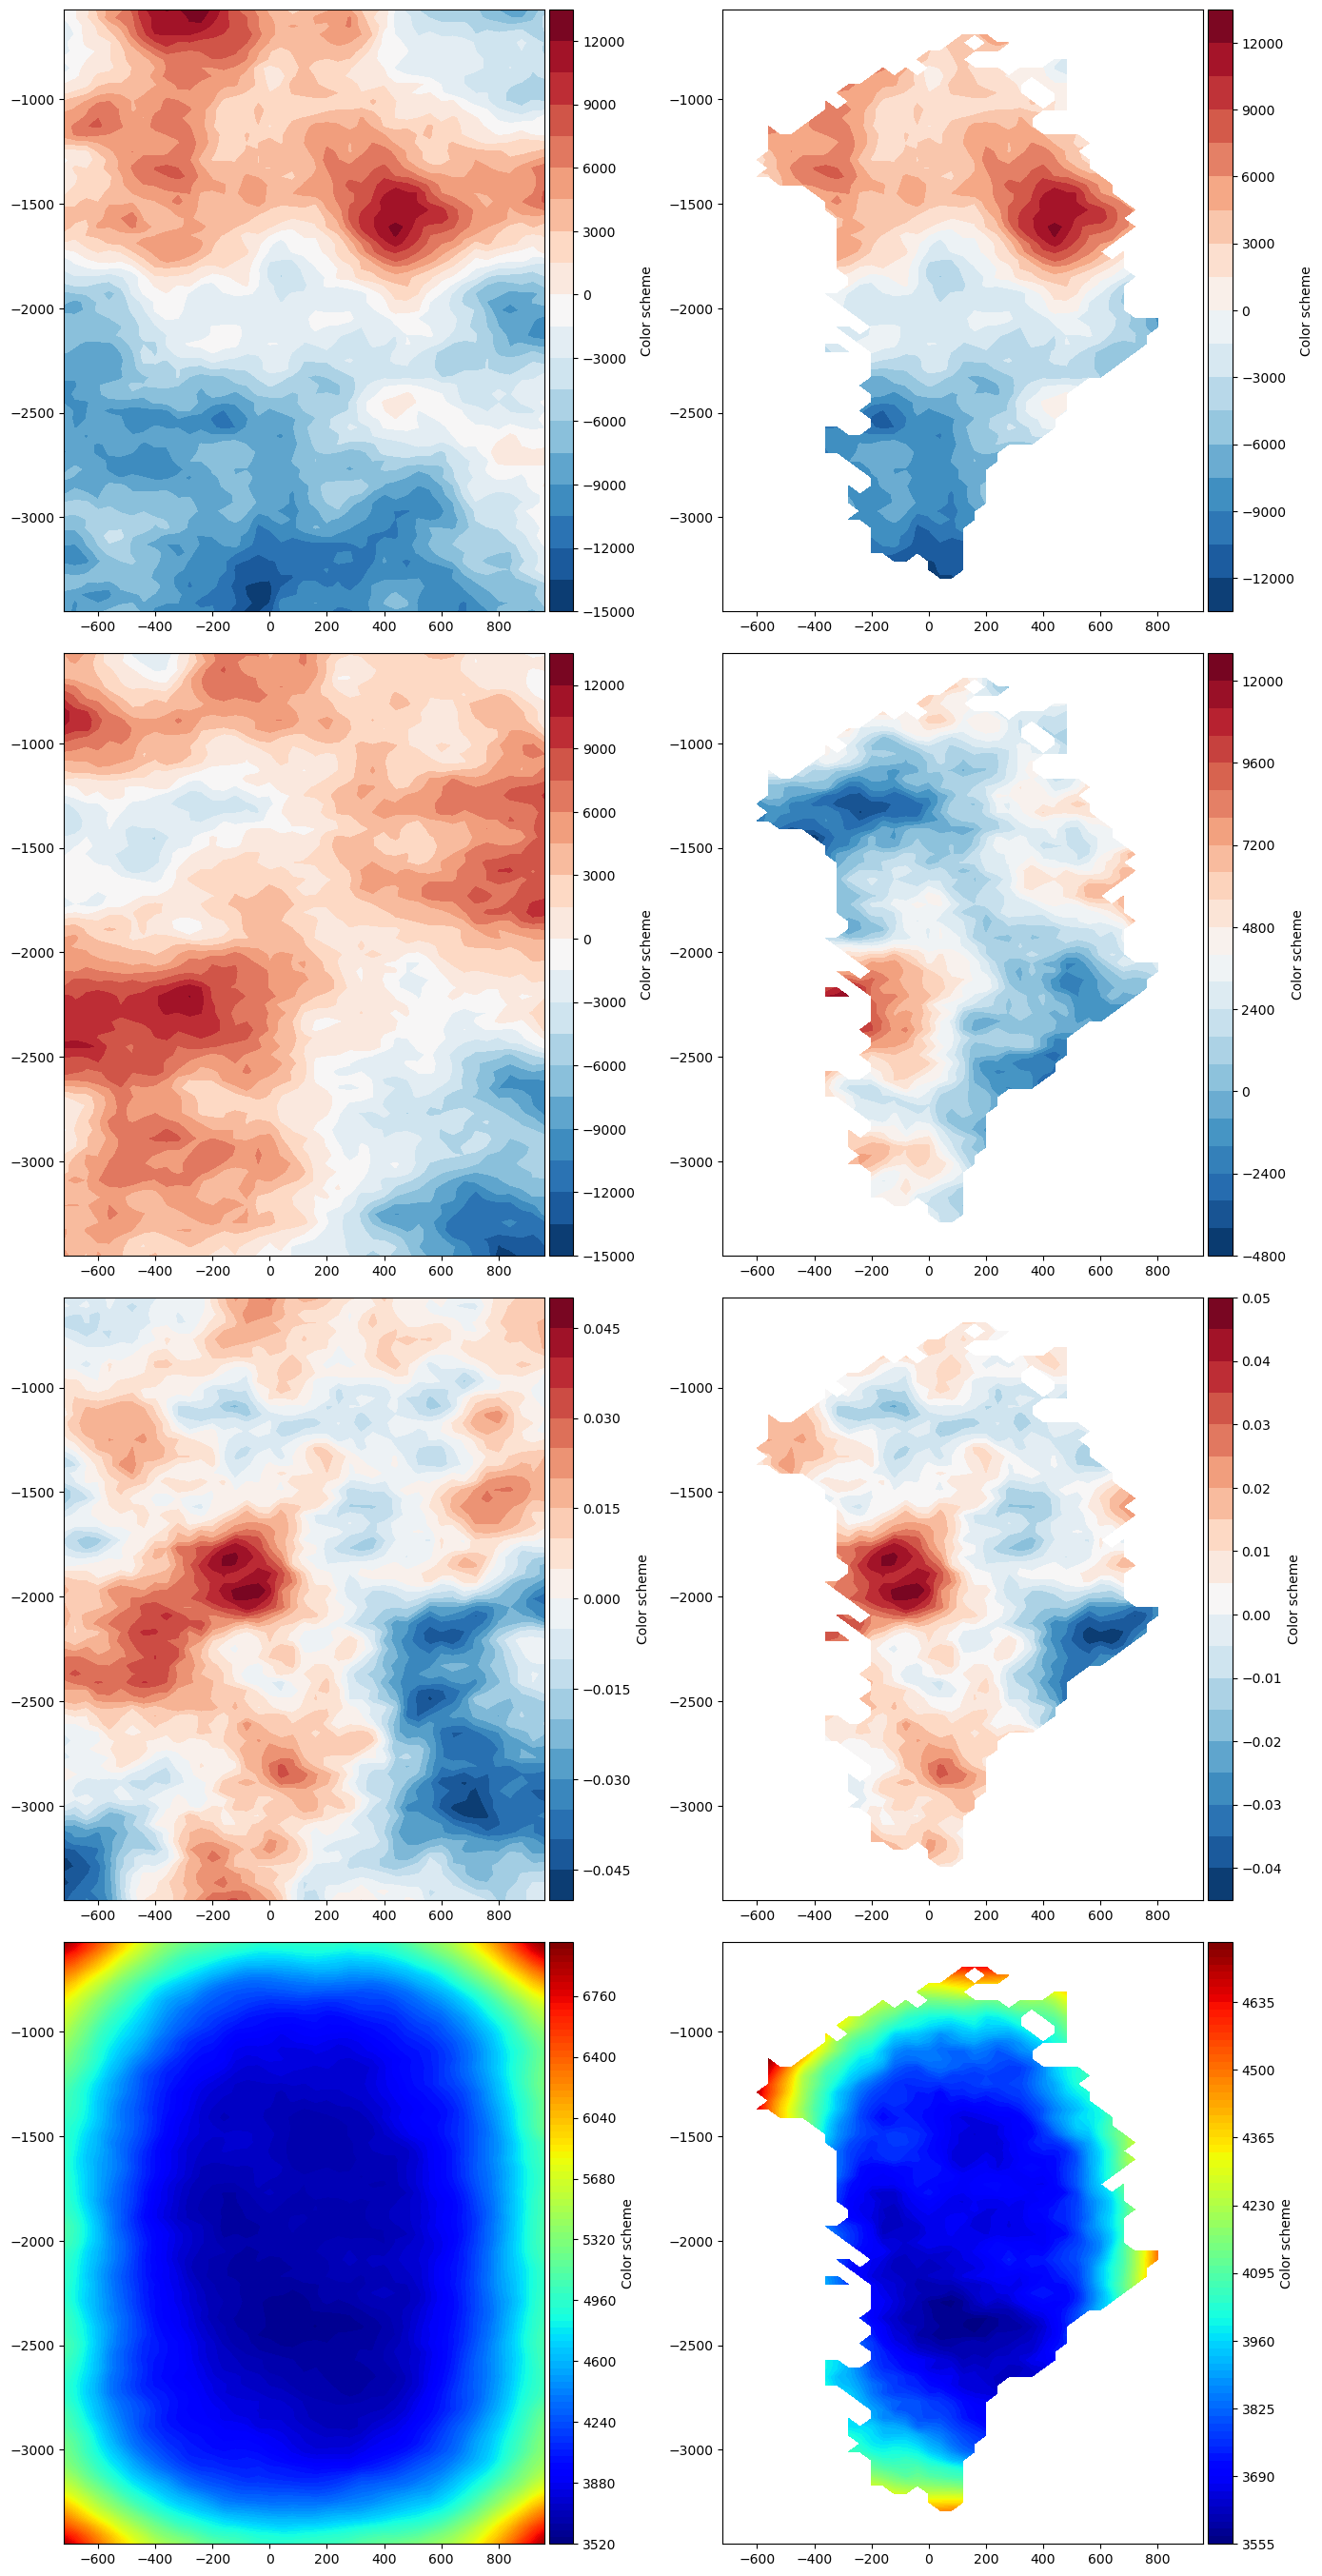

In [4]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini", 2000, None)

ds_prior_X = DA.ds_prior_X.copy()

ds_subset_sample_prior_C_1 = DA.sample_prior_C()
ds_subset_sample_prior_C_2 = DA.sample_prior_C()
ds_mean_samples_prior_C, ds_std_samples_prior_C = DA.ds_prior_C_mean, DA.ds_prior_C_std

ds_subset_sample_prior_1 = DA.sample_prior()
ds_subset_sample_prior_2 = DA.sample_prior()
ds_mean_samples_prior, ds_std_samples_prior = DA.pointwise_marginals("prior", 2000)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_1["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_C_2["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_c_slide_initd"].data/ds_std_samples_prior_C["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior_C["xx_c_slide_initd"].data/ds_std_samples_prior_C["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior_C["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

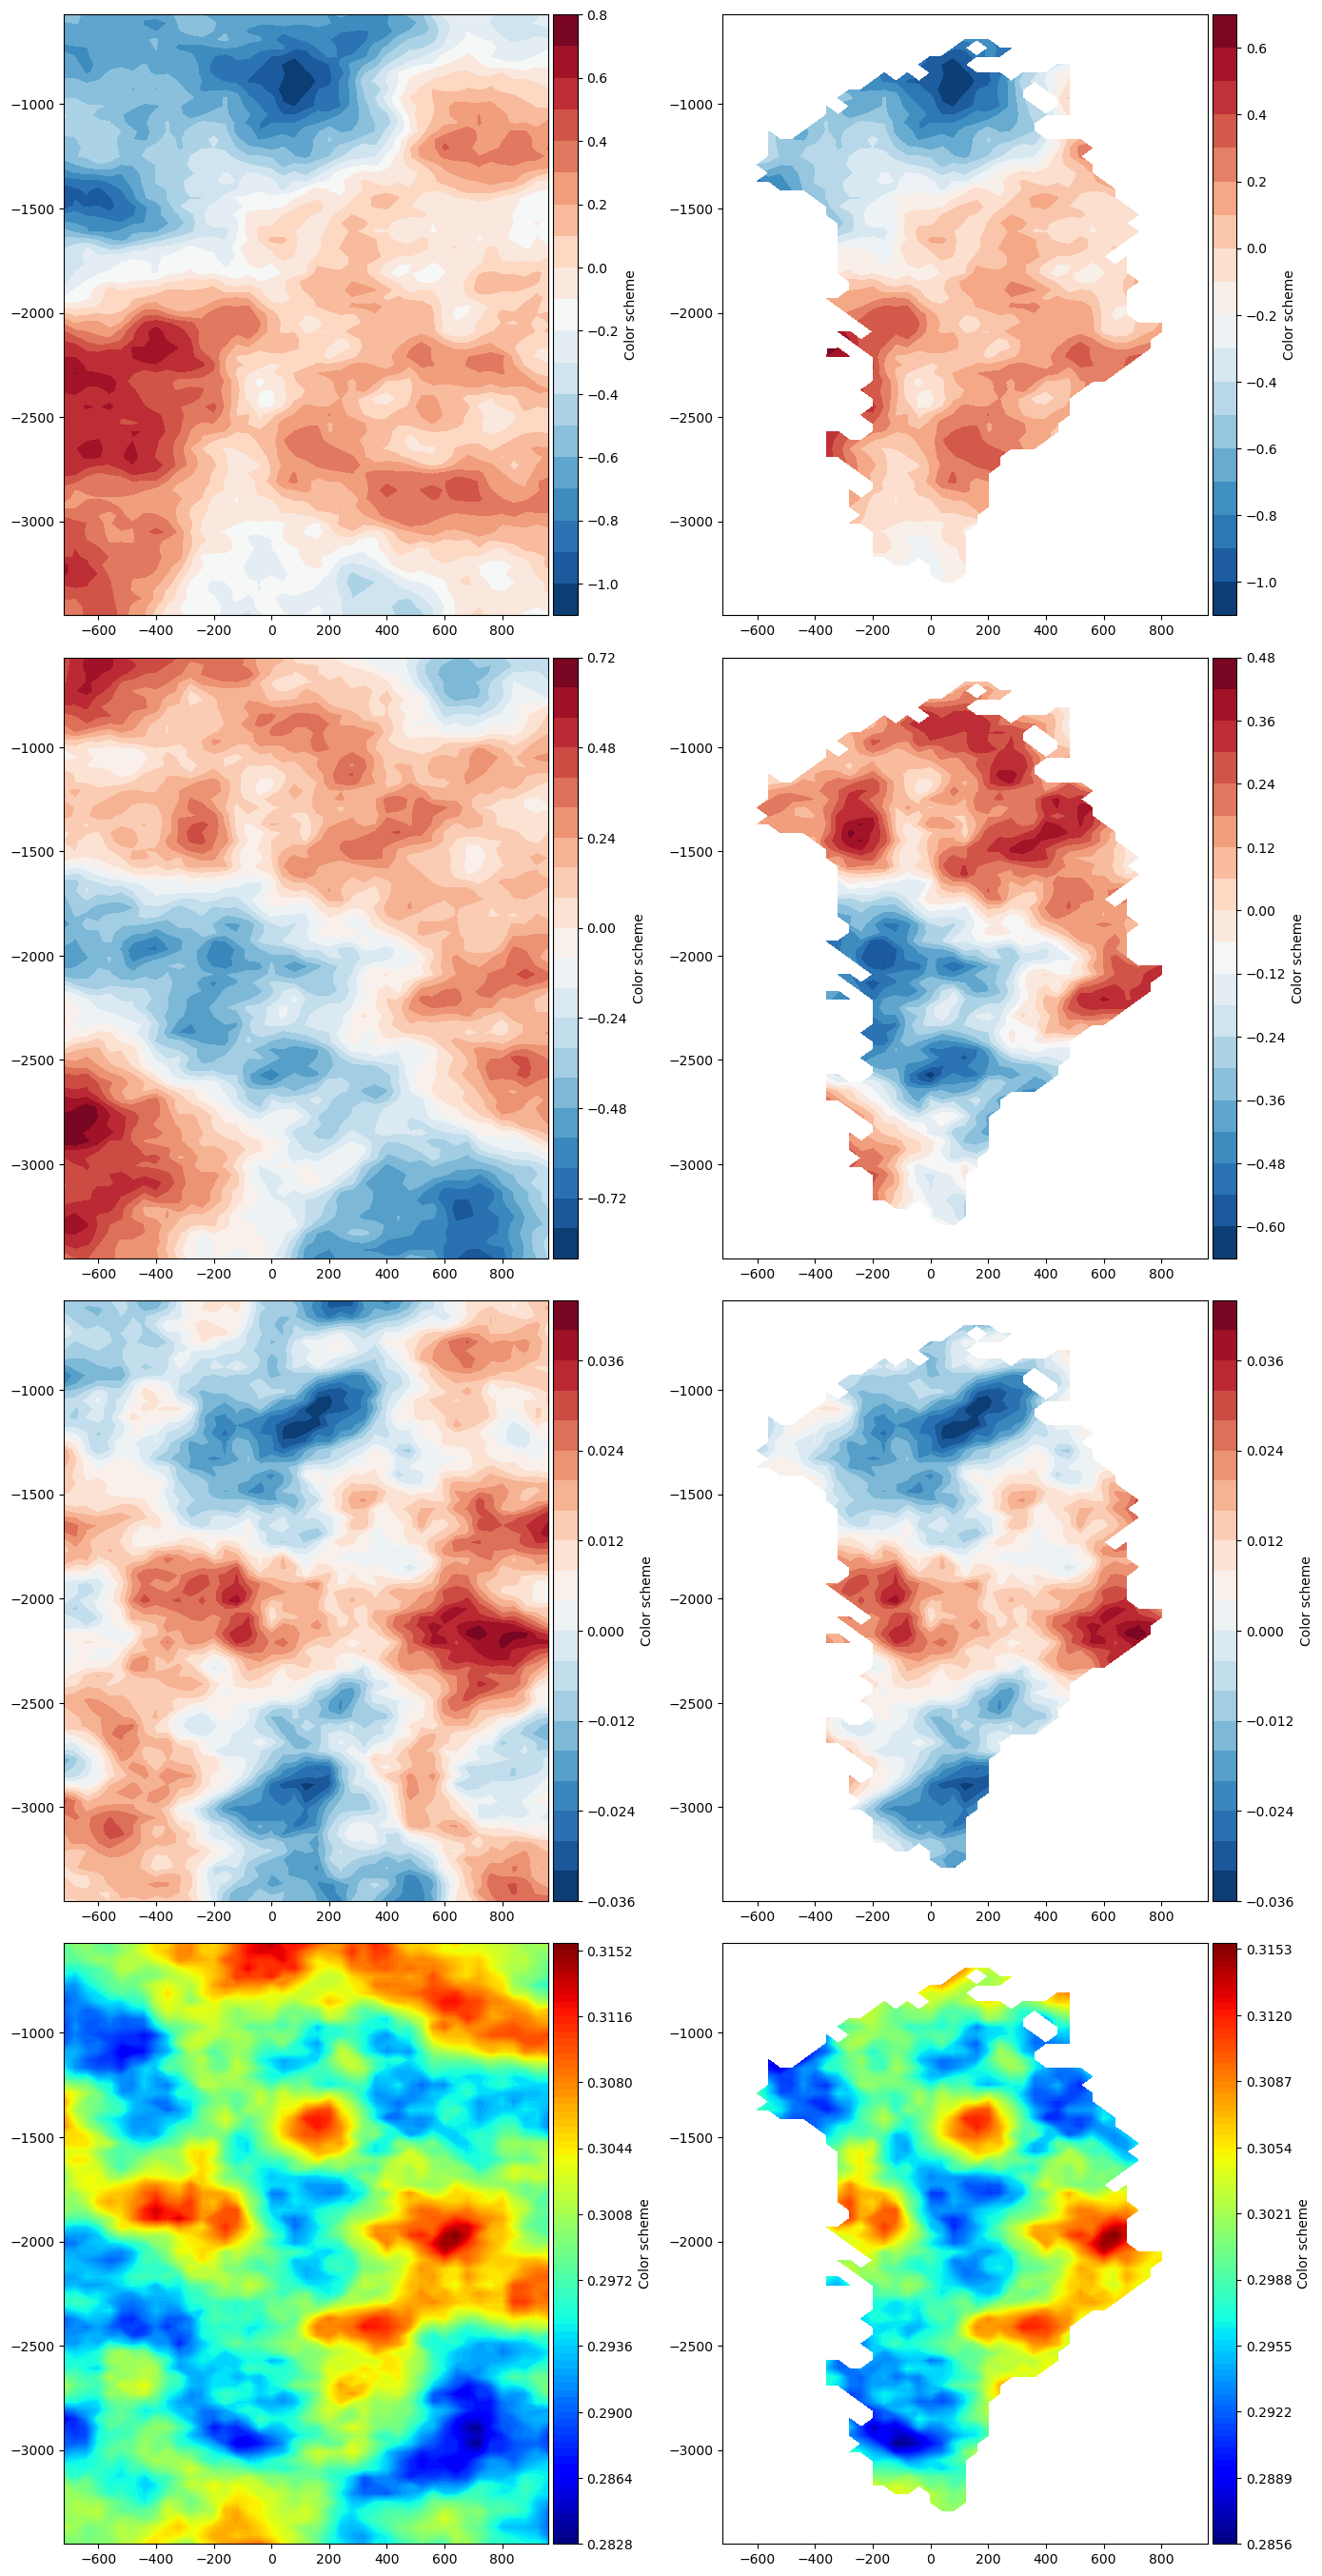

In [5]:
H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

plt.rcParams["figure.figsize"] = (16,24)
n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_1["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_subset_sample_prior_2["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_prior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [6]:
ds_x = DA.create_ad_tlm_action_input_nc(bool_randomize = True)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(25703910.64969381, 25703910.64969381)

In [7]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_H_misfit_x], ["tlm", "adj"]), DA.l2_inner_product([ds_Ax, ds_noise_cov_inv_Ax], ["tlmhessaction", "adjhessaction"])

(25703910.64969381, 25703910.64969381)

In [8]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
    
ds_Ax = DA.eval_tlm_action()
ds_noise_cov_inv_Ax = DA.eval_noise_cov_inv_action(ds_Ax)
ds_H_misfit_x = DA.eval_misfit_hessian_action()

ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")
ds_A_SigmaXCx = DA.eval_tlm_action()
ds_noise_cov_inv_A_SigmaXCx = DA.eval_noise_cov_inv_action(ds_A_SigmaXCx)

dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)

ds_CT_XT_SigmaT_H_misfit_SigmaXCx = DA.eval_prior_preconditioned_misfit_hessian_action()

DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]), DA.l2_inner_product([ds_A_SigmaXCx, ds_noise_cov_inv_A_SigmaXCx], ["tlmhessaction", "adjhessaction"])

(2872891.603092239, 2872891.6030859533)

In [9]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")
ds_SigmaXC_inv_SigmaXCx = DA.eval_sqrt_prior_cov_inv_action()

DA.l2_inner_product([ds_SigmaXC_inv_SigmaXCx, ds_SigmaXC_inv_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"])

(3261.011287690293, 3261.011287690366)

In [10]:
DA.l2_inner_product([ds_SigmaXCx, ds_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"])

(234.80719364424303, 3261.011287690366)

In [11]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()

ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_SigmaXCx = DA.eval_sqrt_prior_cov_action(ad_key_adj_or_tlm_action = "tlm_action")

ds_SigmaXCx_as_adj_fields = xr.open_dataset(DA.dict_ad_inp_nc_files["tlm_action"])
ds_SigmaXCx_as_adj_fields = ds_SigmaXCx_as_adj_fields.rename({field + "d": field + "b" for field in dict_og_params_fields_vals})
for var in ds_SigmaXCx_as_adj_fields:
    if ds_SigmaXCx_as_adj_fields[var].attrs["type"] == "tlm":
        ds_SigmaXCx_as_adj_fields[var].attrs["type"] = "adj"
        if dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "2D":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1))
        elif dict_params_fields_or_scalars[var[:-1]] == "scalar" and dict_params_fields_num_dims[var[:-1]] == "3D":
            ds_SigmaXCx_as_adj_fields[var].data[:, :] = ds_SigmaXCx_as_adj_fields[var].data.flat[0]/((IMAX+1)*(JMAX+1)*(KCMAX+1))
ds_SigmaXCx_as_adj_fields.to_netcdf(DA.dict_ad_out_nc_files["adj_action"])

ds_CT_XT_SigmaT_SigmaXCx = DA.eval_sqrt_prior_covT_action(ad_key_adj_or_adj_action = "adj_action")

DA.l2_inner_product([ds_SigmaXCx, ds_SigmaXCx], ["tlm", "tlm"]), DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_SigmaXCx], ["tlm", "adj"])

(234.80719364424303, 234.8071936443938)

In [12]:
dict_tlm_action_only_fields_vals = {}
for var in ds_x:
    if DA.dict_tlm_action_fields_or_scalars[var] == "scalar":
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data[0].copy()
    else:
        dict_tlm_action_only_fields_vals[var] = ds_x[var].data.copy()
ds_x = DA.create_ad_tlm_action_input_nc(dict_tlm_action_only_fields_vals)
ds_CT_XT_SigmaT_H_SigmaXCx = DA.eval_prior_preconditioned_hessian_action()

DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]), \
DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_misfit_SigmaXCx], ["tlm", "adj"]) + DA.l2_inner_product([ds_x, ds_x], ["tlm", "tlm"]), \
DA.l2_inner_product([ds_x, ds_CT_XT_SigmaT_H_SigmaXCx], ["tlm", "adj"])

(2872891.603092239, 2876152.614379929, 2876152.6143799294)

---------------------------------------------------------------------------------------------------------------
iter 0, fc = 37967353.32671733, fc_data = 37967353.32671733, fc_reg = 0.0
---------------------------------------------------------------------------------------------------------------
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Too big step size probably crashed the simulation.
Step size alpha = 4.76837158203125e-07
------------------------------------------------------------------------------------------------------

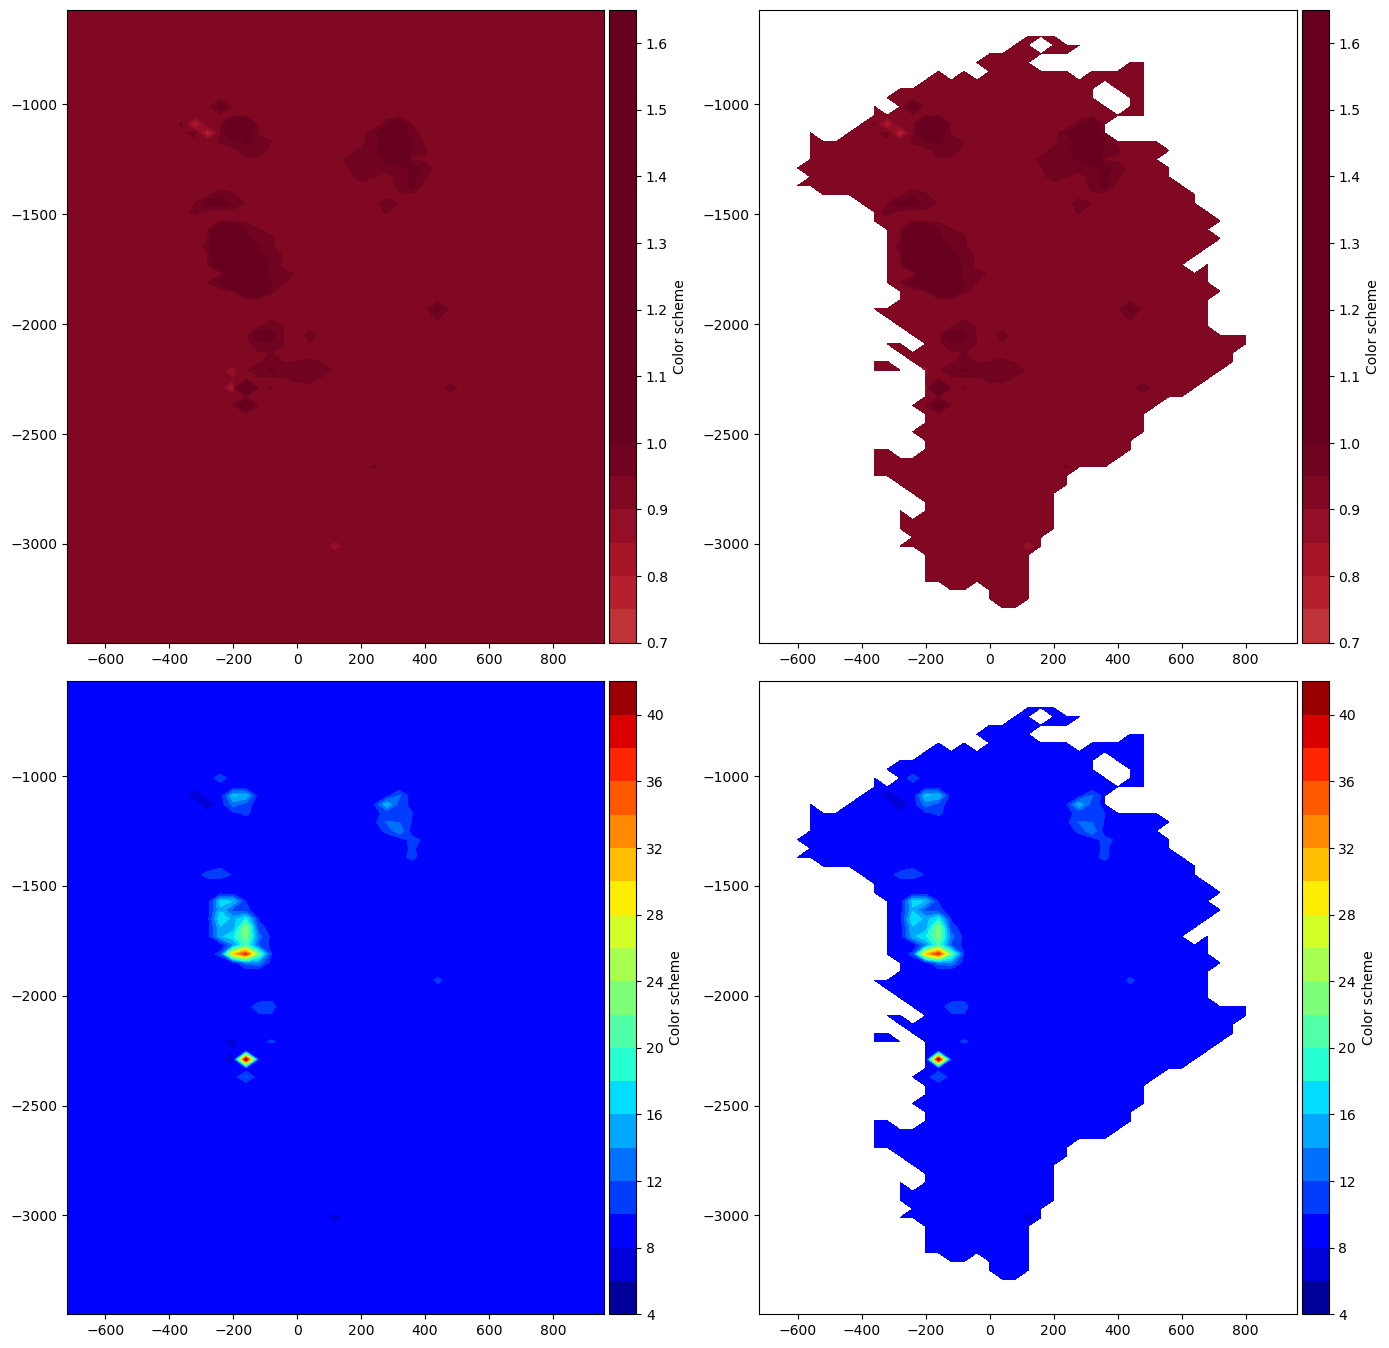

In [13]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini", None, ds_prior_X)

ds = DA.gradient_descent(2, init_alpha = 1.0, min_alpha_tol = 1.e-10)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 2, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data,
                         cmap = 'RdBu_r', nbins = 20, vmin = -1, vmax = 1, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -1, vmax = 1, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data*mask,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 1])
plt.tight_layout()

---------------------------------------------------------------------------------------------------------------
Initial fc = 37967353.32671733, fc_data = 37967353.32671733, fc_reg = 0.0
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 2006150.3226627875, norm_r_hat: 783268.5769466382
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  180.0
Step size alpha = 1.0
---------------------------------------------------------------------------------------------------------------
Outer iter 1, fc = 36931998.47463249, fc_data = 36931996.903956614, fc_reg = 1.5706758724116443
---------------------------------------------------------------------------------------------------------------
CG iter 1
eps_TOL_CG: 5394068.22273323, norm_r_hat: 1401550.6702290839
conjugate_gradient: Convergence.
Angle between p_hat and g_hat in degrees:  179.99999879258172
Step size alpha = 1.0
------------------

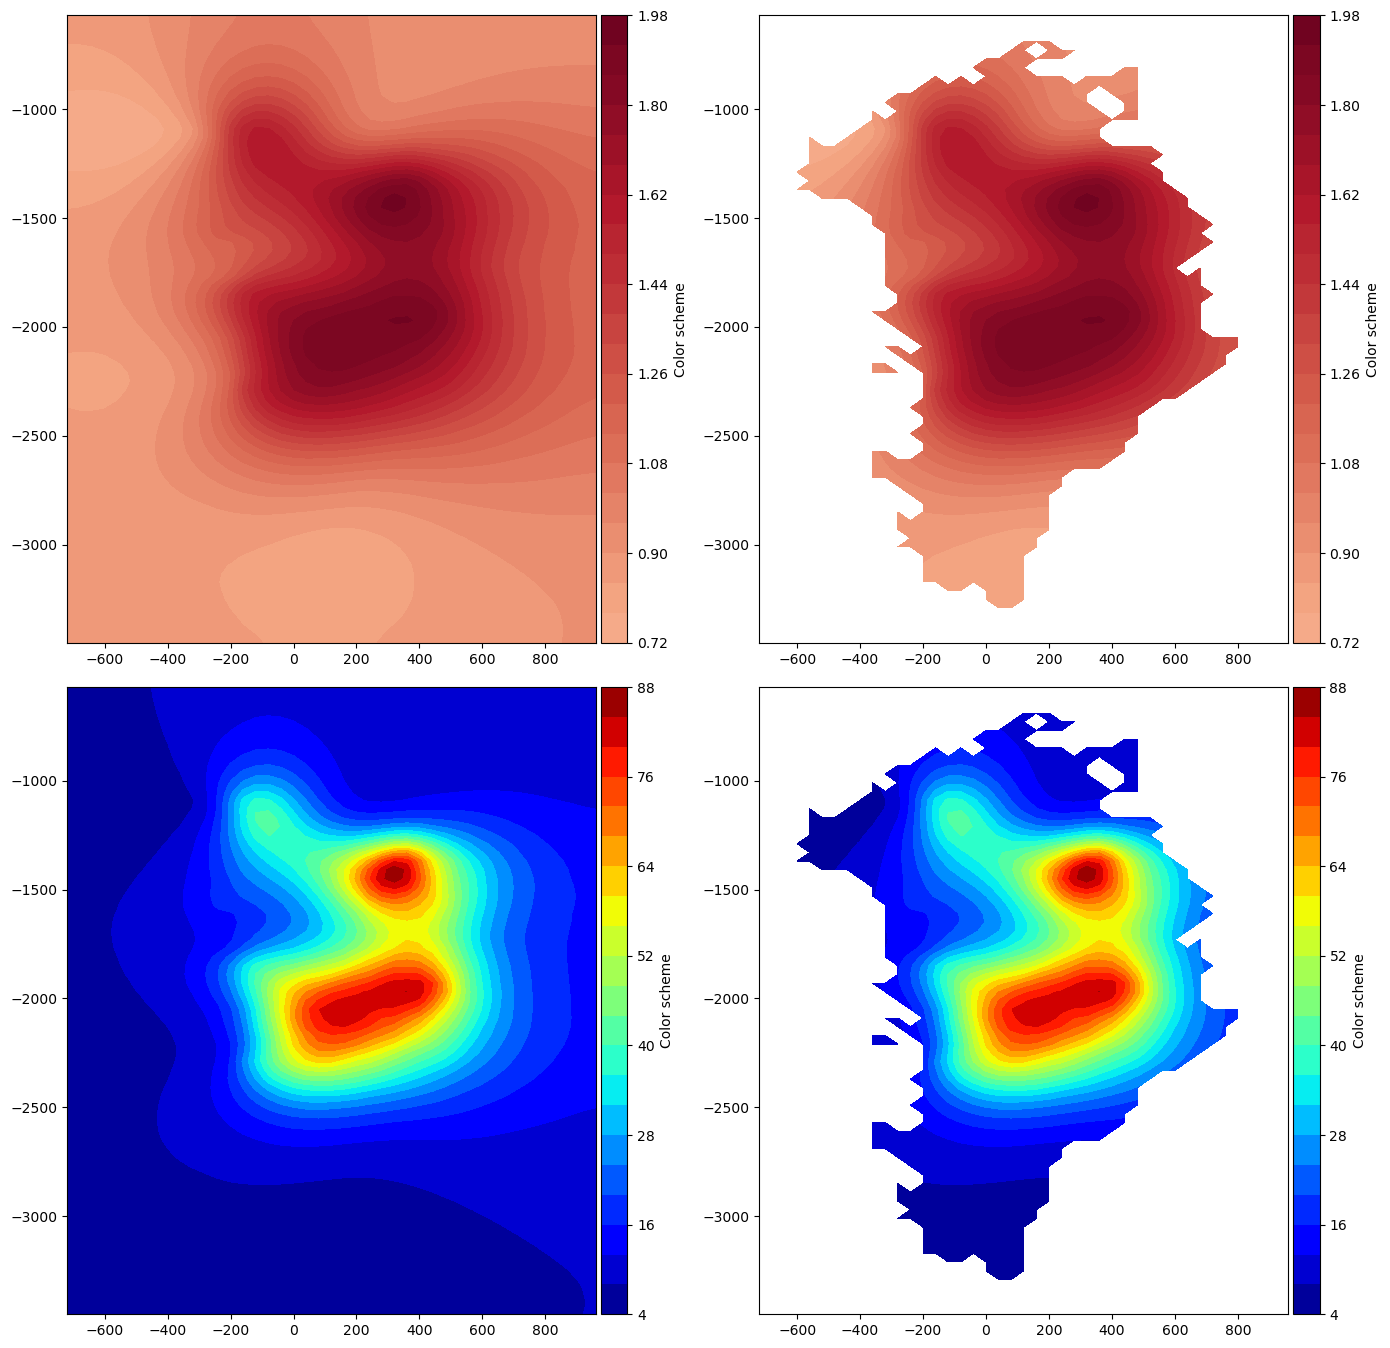

In [14]:
DA = optim.DataAssimilation(sicopolis_dir, simulation,
                            dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
                            dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
                            dict_og_params_fields_vals, dict_params_fields_num_dims, 
                            dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
                            dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
                            MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini", None, ds_prior_X)

ds = DA.inexact_gn_hessian_cg(MAX_ITERS=5, min_alpha_cg_tol = 1.e-20, init_alpha_gd = 1.e-6, min_alpha_gd_tol = 1.e-20)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 2, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -2, vmax = 2, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         10**ds["xx_c_slide_init"].data*mask,
                         cmap = 'jet', nbins = 20, fig = fig, ax = ax[1, 1])
plt.tight_layout()

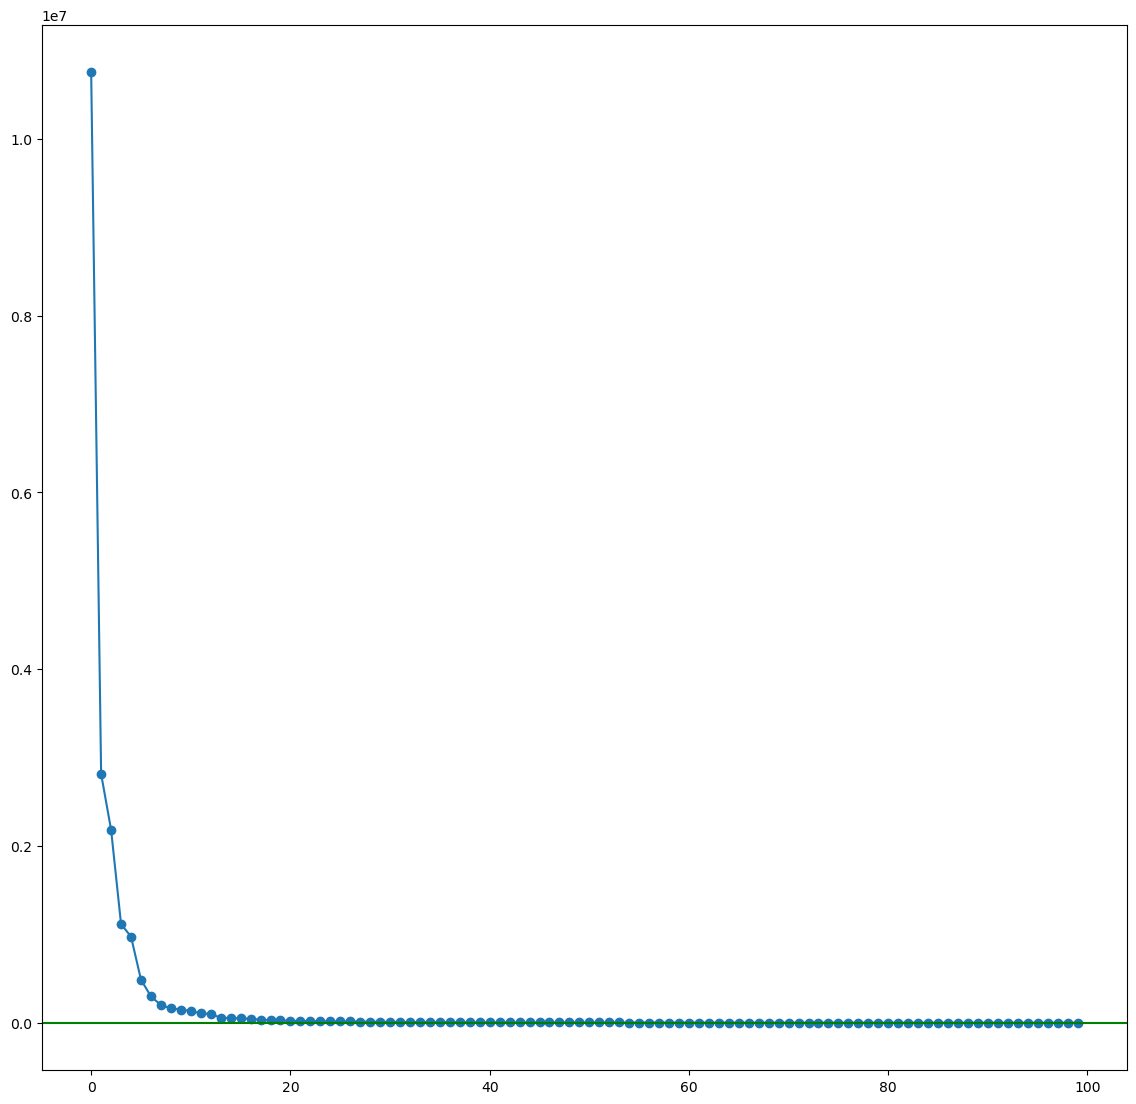

In [15]:
U_misfit, Lambda_misfit, Q_misfit, S_misfit = DA.revd(45, 5, mode = "misfit_prior_precond")
U_misfit, Lambda_misfit, Q_misfit, S_misfit = DA.revd(45, 5, mode = "misfit_prior_precond", Q = Q_misfit)

plt.scatter(np.arange(Lambda_misfit.shape[0]), np.sort(Lambda_misfit)[::-1])
plt.plot(np.sort(Lambda_misfit)[::-1])

plt.axhline(1, color = "green")

In [16]:
np.sort(Lambda_misfit)[::-1]

array([1.07564834e+07, 2.81527058e+06, 2.18311734e+06, 1.11651491e+06,
       9.74716259e+05, 4.87077671e+05, 2.98913543e+05, 2.01034359e+05,
       1.62417539e+05, 1.49769825e+05, 1.33400893e+05, 1.07309599e+05,
       9.83946389e+04, 5.83061357e+04, 5.27583650e+04, 5.14518562e+04,
       4.37081490e+04, 3.49297975e+04, 3.00884985e+04, 2.77147720e+04,
       2.20868447e+04, 2.02958708e+04, 1.94845545e+04, 1.82913133e+04,
       1.61232949e+04, 1.56131158e+04, 1.51024586e+04, 1.44879347e+04,
       1.20905796e+04, 1.19508335e+04, 1.06098523e+04, 9.72551322e+03,
       8.63834338e+03, 8.29266180e+03, 8.02277063e+03, 7.61263978e+03,
       7.14028068e+03, 6.65941594e+03, 6.49306060e+03, 6.27799266e+03,
       5.87877955e+03, 5.75579349e+03, 5.40090810e+03, 5.23171319e+03,
       4.82800780e+03, 4.67977274e+03, 4.35377839e+03, 4.13713975e+03,
       4.02433471e+03, 3.75547968e+03, 3.64760372e+03, 3.53918598e+03,
       3.39213860e+03, 3.24396470e+03, 3.20458990e+03, 3.10186066e+03,
      

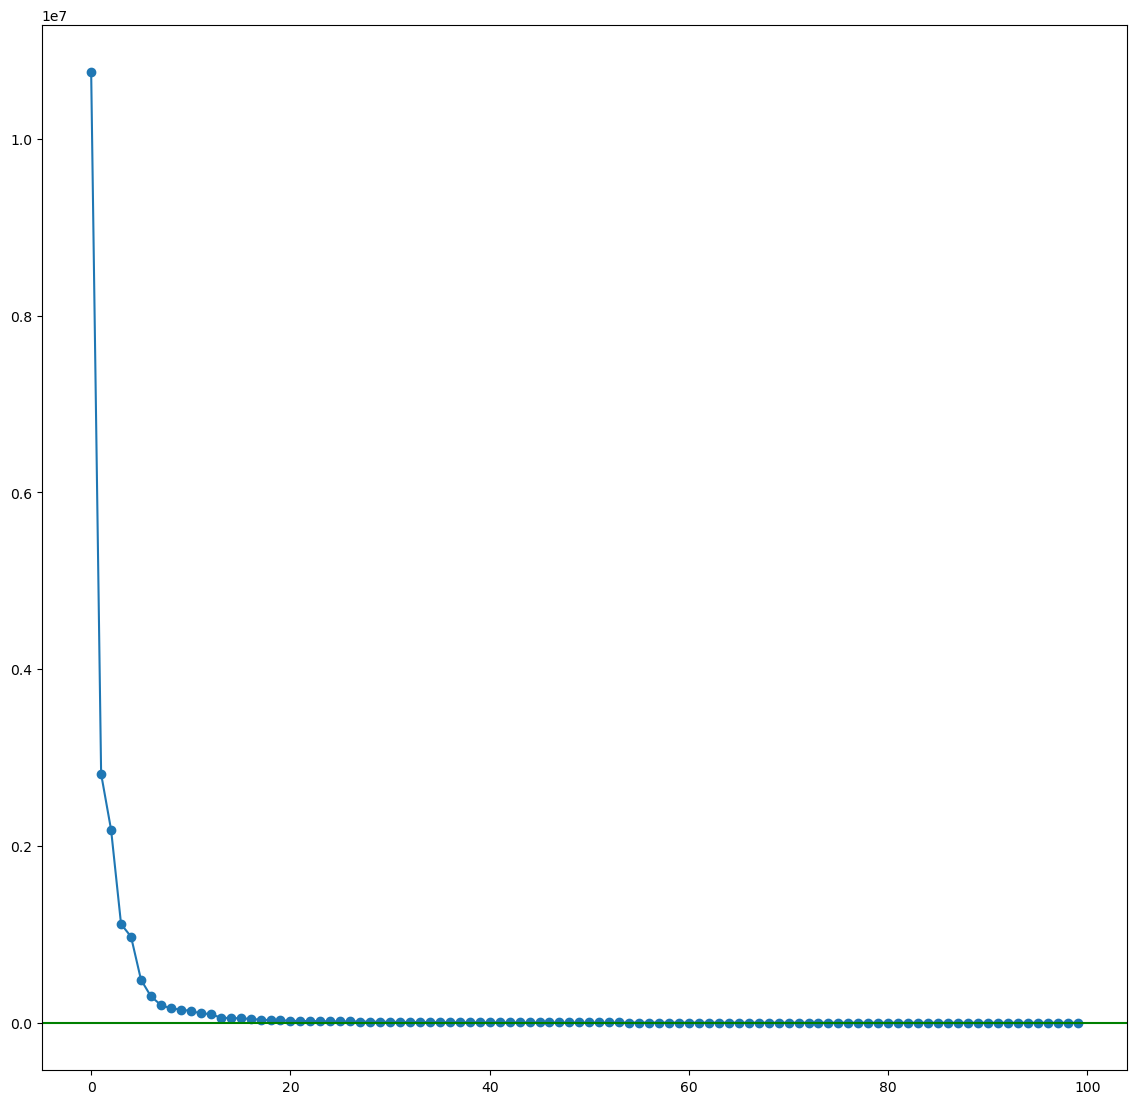

In [17]:
U_misfit, Lambda_misfit, Q_misfit, S_misfit = DA.revd(45, 5, mode = "misfit_prior_precond")
Q_misfit = np.load("/scratch2/shreyas/tuneCS_mini/REVD/Q_misfit.npy")
U_misfit, Lambda_misfit, Q_misfit, S_misfit = DA.revd(45, 5, mode = "misfit_prior_precond", Q = Q_misfit)

plt.scatter(np.arange(Lambda_misfit.shape[0]), np.sort(Lambda_misfit)[::-1])
plt.plot(np.sort(Lambda_misfit)[::-1])

plt.axhline(1, color = "green")

In [18]:
np.sort(Lambda_misfit)[::-1]

array([1.07564834e+07, 2.81527059e+06, 2.18311688e+06, 1.11651493e+06,
       9.74715926e+05, 4.87077473e+05, 2.98916140e+05, 2.01033324e+05,
       1.62422703e+05, 1.49770194e+05, 1.33399633e+05, 1.07311960e+05,
       9.83824945e+04, 5.82873136e+04, 5.27520694e+04, 5.14497774e+04,
       4.37146191e+04, 3.49251283e+04, 3.00891480e+04, 2.77004027e+04,
       2.20668898e+04, 2.03002745e+04, 1.94985647e+04, 1.83332505e+04,
       1.60875766e+04, 1.55795510e+04, 1.51054790e+04, 1.44918513e+04,
       1.20465402e+04, 1.19268527e+04, 1.05740369e+04, 9.70676601e+03,
       8.67093375e+03, 8.29023130e+03, 7.98775246e+03, 7.56695948e+03,
       7.12299306e+03, 6.68428956e+03, 6.53367252e+03, 6.26853162e+03,
       5.86916758e+03, 5.72520073e+03, 5.40947749e+03, 5.24726092e+03,
       4.71375577e+03, 4.69601385e+03, 4.33052463e+03, 4.11875391e+03,
       4.06715163e+03, 3.79299755e+03, 3.58641632e+03, 3.56523027e+03,
       3.37720180e+03, 3.34140215e+03, 3.07015083e+03, 3.02436060e+03,
      

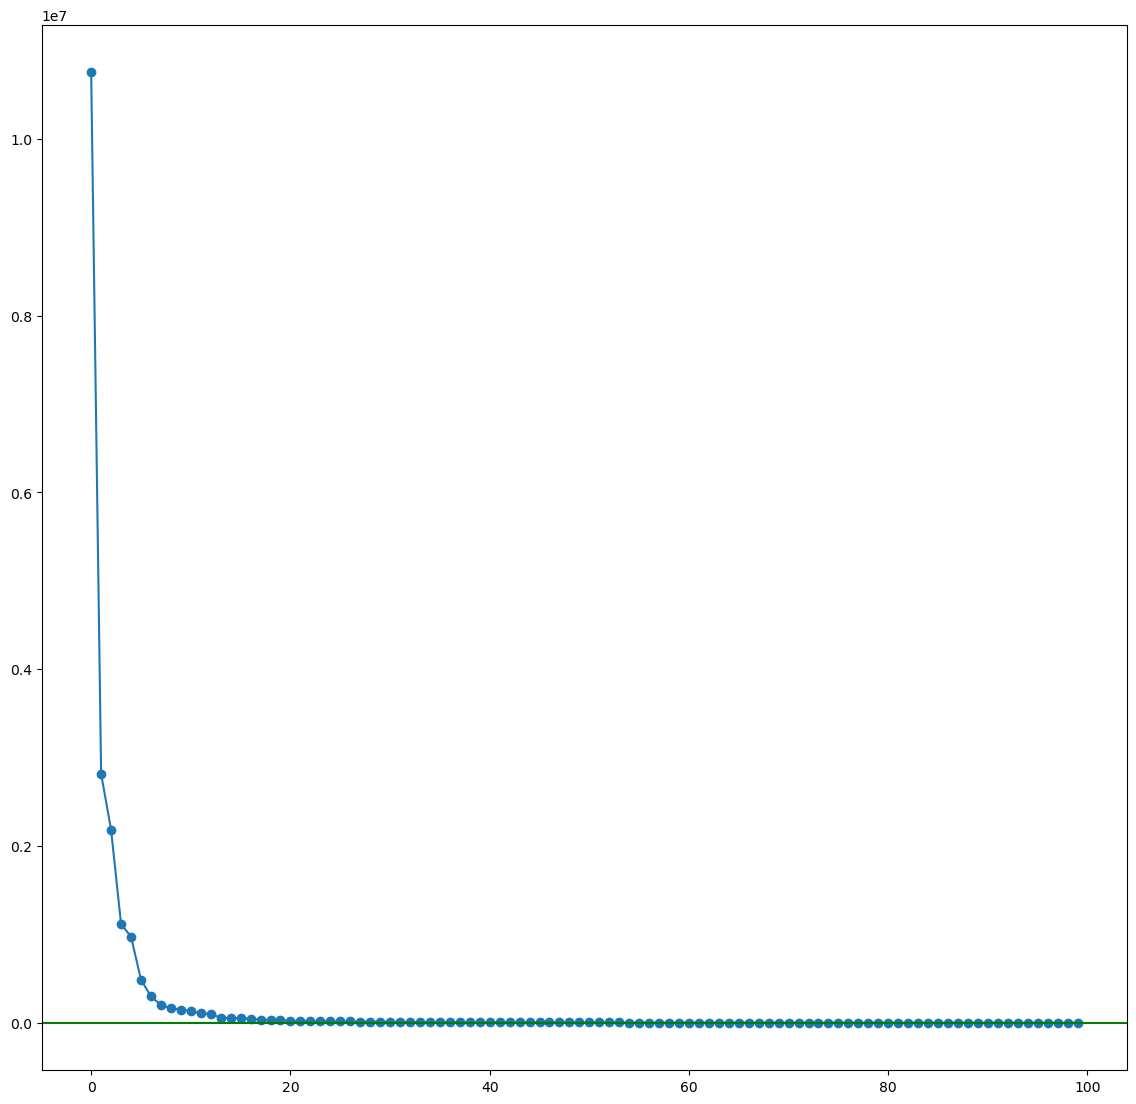

In [19]:
U_misfit, Lambda_misfit, Q_misfit, S_misfit = DA.revd(90, 10, mode = "misfit_prior_precond")

plt.scatter(np.arange(Lambda_misfit.shape[0]), np.sort(Lambda_misfit)[::-1])
plt.plot(np.sort(Lambda_misfit)[::-1])

plt.axhline(1, color = "green")

In [20]:
np.sort(Lambda_misfit)[::-1]

array([1.07564834e+07, 2.81527066e+06, 2.18311701e+06, 1.11651421e+06,
       9.74715952e+05, 4.87076541e+05, 2.98916186e+05, 2.01036113e+05,
       1.62418036e+05, 1.49771427e+05, 1.33396139e+05, 1.07306958e+05,
       9.83897195e+04, 5.82955888e+04, 5.27546558e+04, 5.14578658e+04,
       4.37095969e+04, 3.49215038e+04, 3.01143577e+04, 2.77088844e+04,
       2.20597492e+04, 2.02992591e+04, 1.94877189e+04, 1.83058971e+04,
       1.61053187e+04, 1.56072267e+04, 1.50892761e+04, 1.44862625e+04,
       1.20980300e+04, 1.19285483e+04, 1.06122137e+04, 9.74505885e+03,
       8.50944566e+03, 8.29037504e+03, 7.98333069e+03, 7.63858710e+03,
       7.23481748e+03, 6.68349179e+03, 6.51312657e+03, 6.15208150e+03,
       5.85331650e+03, 5.70773368e+03, 5.41008152e+03, 5.18529215e+03,
       4.72567252e+03, 4.64084587e+03, 4.30101819e+03, 4.15909250e+03,
       4.03366851e+03, 3.76204629e+03, 3.67120053e+03, 3.55034828e+03,
       3.41336530e+03, 3.31516456e+03, 3.11047168e+03, 3.04716725e+03,
      

In [21]:
sigma_B_squared, sigma_P_squared, delta_sigma_qoi_squared = DA.forward_uq_propagation(U_misfit, Lambda_misfit)
sigma_B_squared, sigma_P_squared, delta_sigma_qoi_squared

(1.0021004718840507e+21, 7.898245598652284e+18, 0.992118309670284)

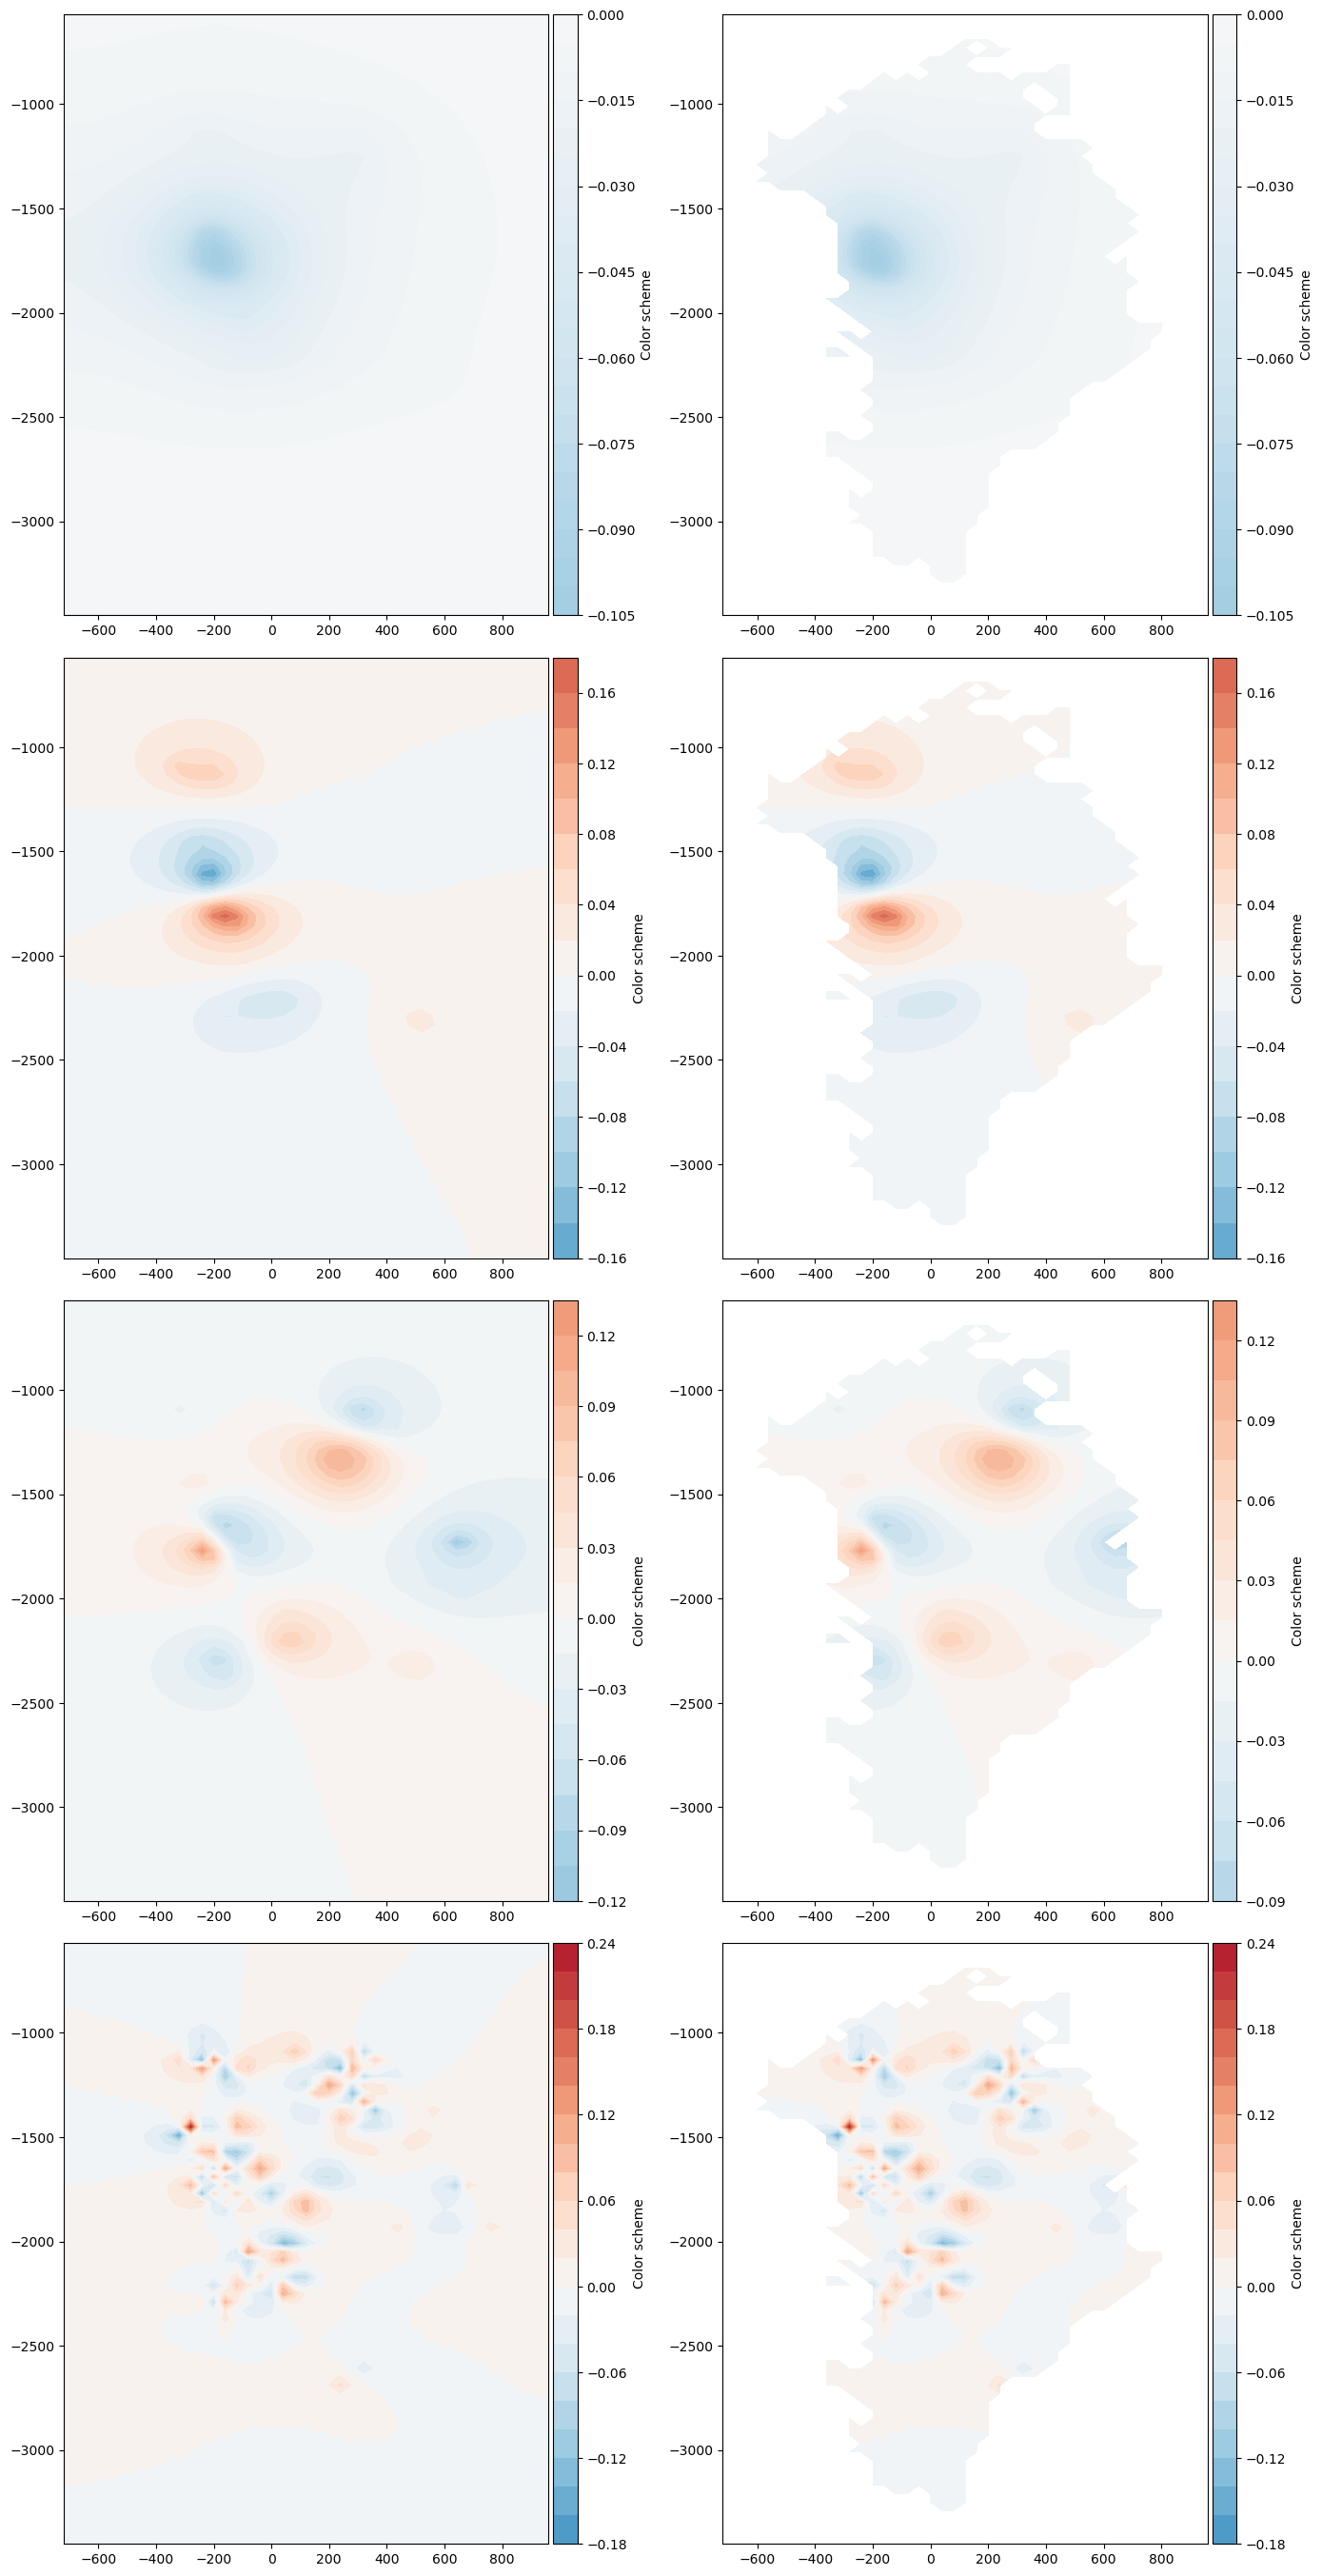

In [22]:
U_misfit_reshaped = np.reshape(U_misfit, (73, 43, -1))

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 0],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 0]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 5],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 5]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 10],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, 10]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, -1],
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         U_misfit_reshaped[:, :, -1]*mask,
                         cmap = 'RdBu_r', nbins = 20, vmin = -0.3, vmax=0.3, fig = fig, ax = ax[3, 1])
plt.tight_layout()

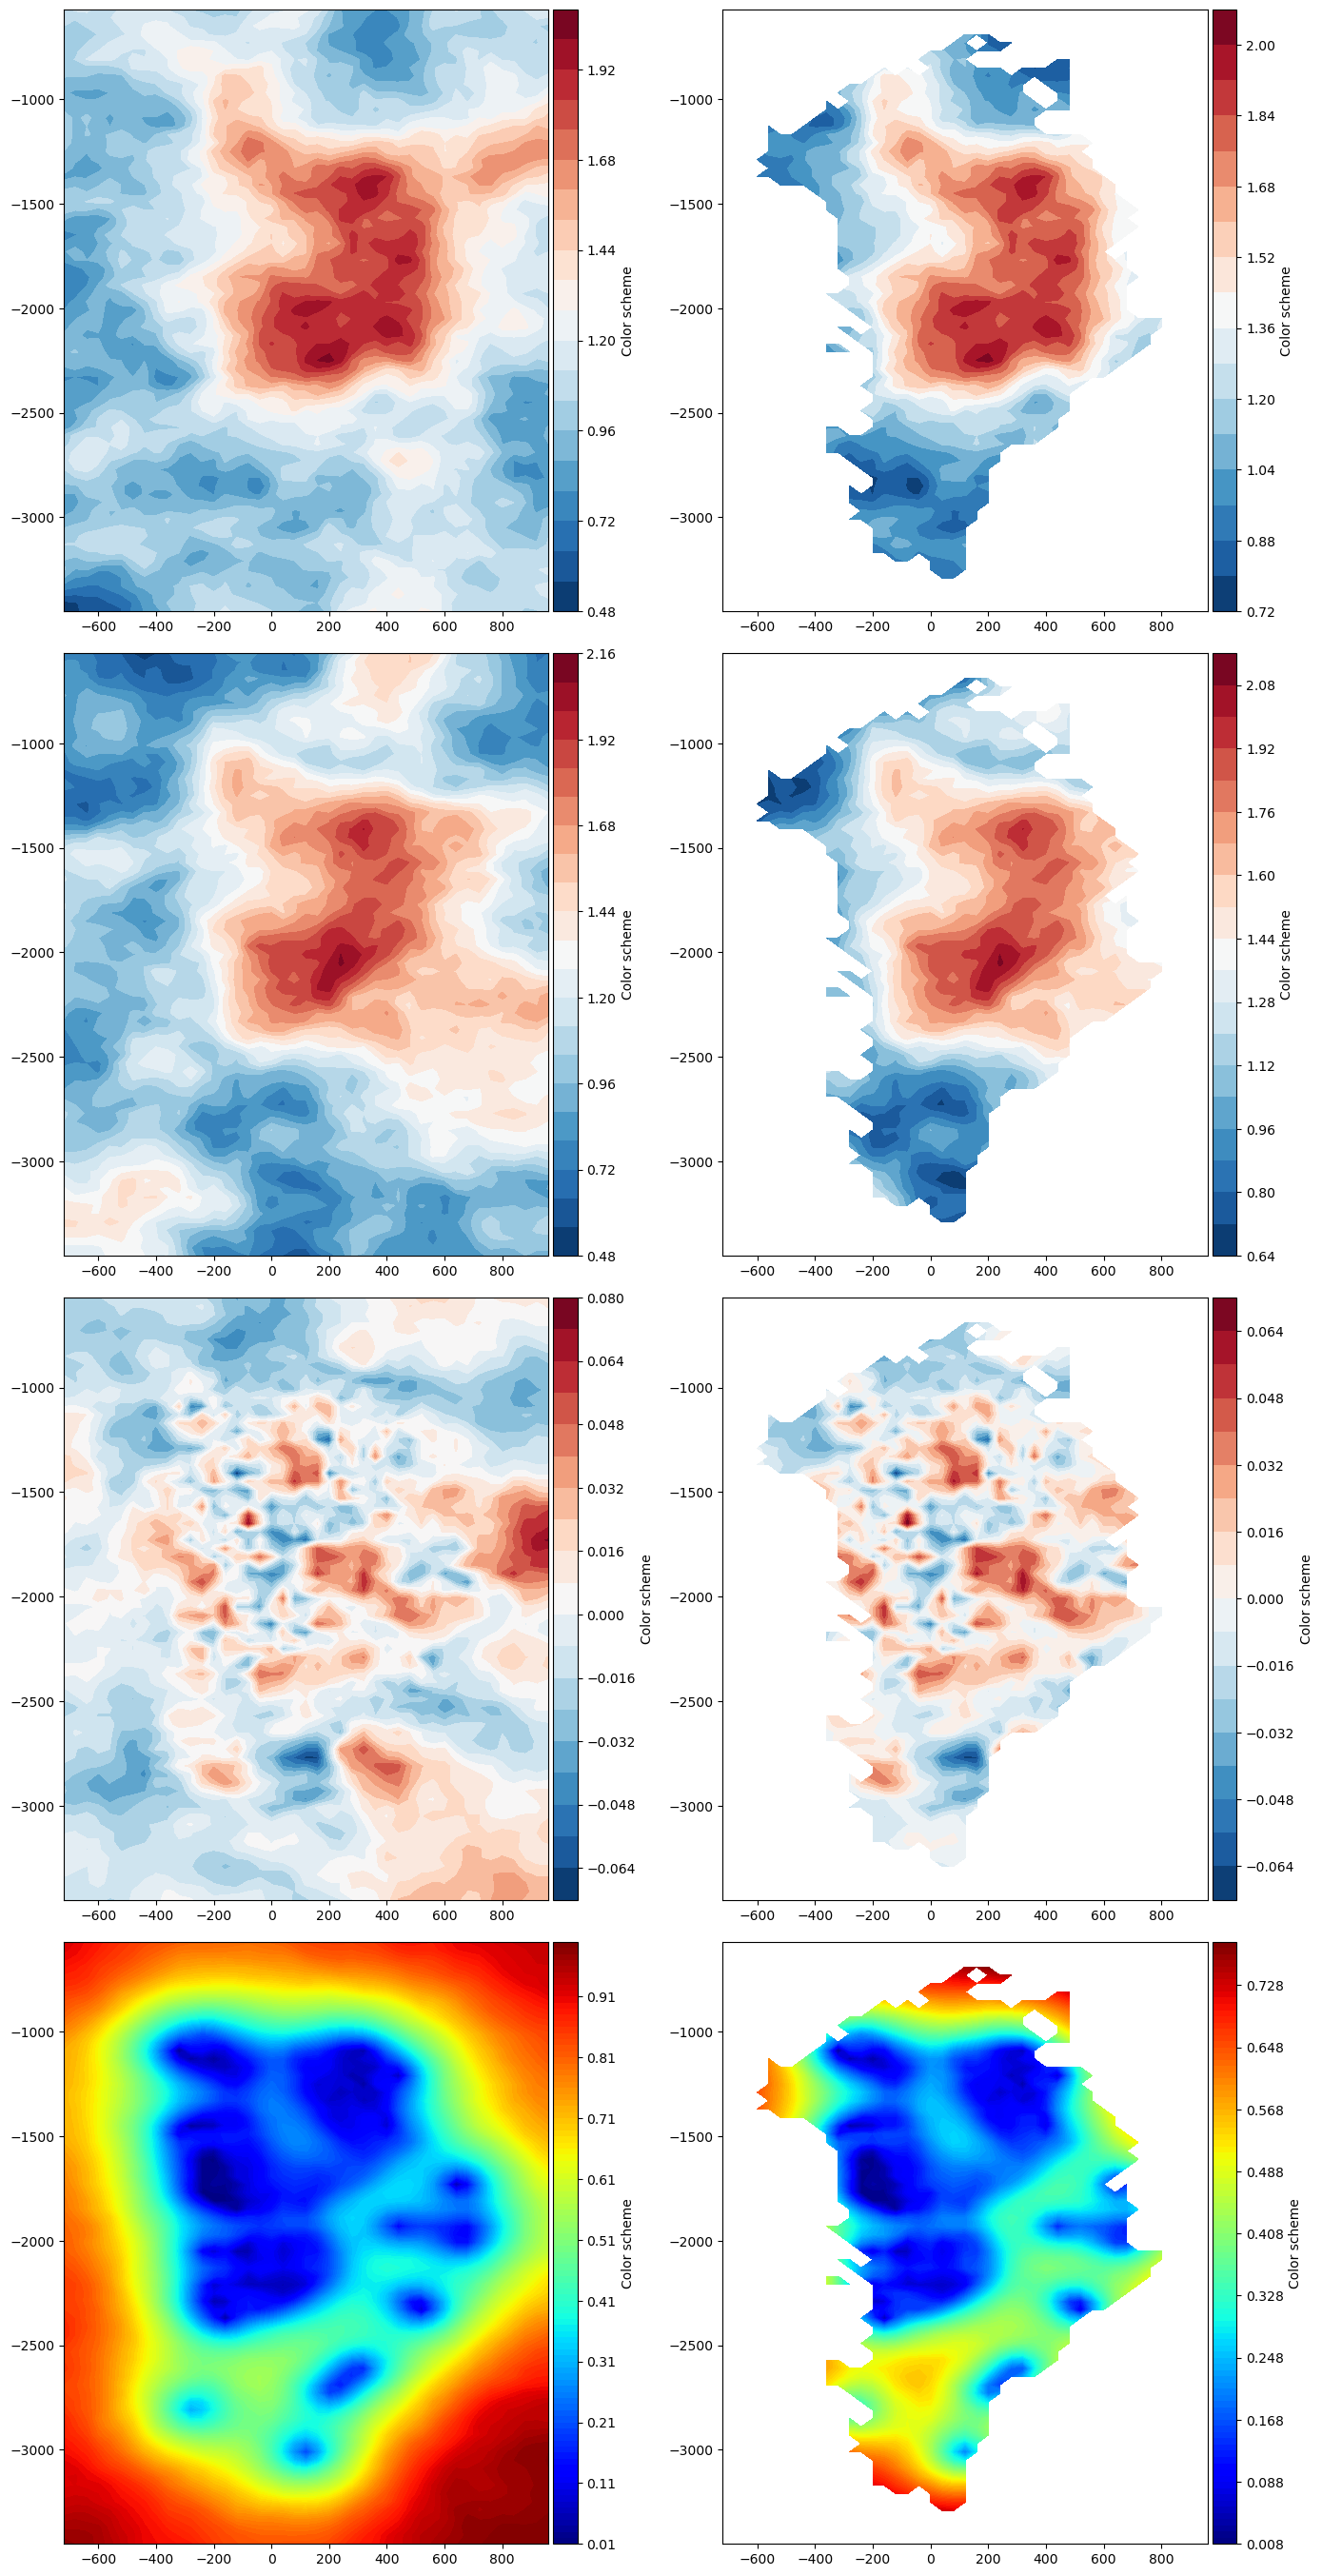

In [23]:
ds_subset_sample_posterior_1 = DA.sample_posterior(U_misfit, Lambda_misfit)
ds_subset_sample_posterior_2 = DA.sample_posterior(U_misfit, Lambda_misfit)
ds_mean_samples_posterior, ds_std_samples_posterior = DA.pointwise_marginals("posterior", 2000, U_misfit, Lambda_misfit)

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
H_data = H_data_40["H"].data
mask = 1.0*(H_data > 0)
mask[mask == 0] = np.nan

n_rows, n_cols = 4, 2
aspect_ratio = len(xModel40)/len(yModel40)
subplot_width = 4
subplot_height = subplot_width / aspect_ratio
plt.rcParams["figure.figsize"] = ((n_cols+1.5)*subplot_width, n_rows*subplot_height)
fig, ax = plt.subplots(n_rows, n_cols)

fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_1["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[0, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         (ds["xx_c_slide_init"].data + ds_subset_sample_posterior_2["xx_c_slide_initd"].data)*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[1, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_mean_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_posterior["xx_c_slide_initd"].data*mask,
                         cmap = 'RdBu_r', nbins = 20, fig = fig, ax = ax[2, 1])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 0])
fancyPlotter.plot_normal(xModel40, 
                         yModel40, 
                         ds_std_samples_posterior["xx_c_slide_initd"].data/ds_std_samples_prior["xx_c_slide_initd"].data*mask,
                         cmap = 'jet', nbins = 100, fig = fig, ax = ax[3, 1])
plt.tight_layout()

In [24]:
# DA = optim.DataAssimilation(sicopolis_dir, simulation,
#                             dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
#                             dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
#                             dict_og_params_fields_vals, dict_params_fields_num_dims, 
#                             dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables, 
#                             dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas, 
#                             MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/tuneCS_mini", None, ds_prior_X)

# DA.l_bfgs(5, 3)